In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from tqdm import tqdm
import datetime as dt
import pickle

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import pdaactconn as pc
from trialexplorer.mesh_terms import MeSHCatalog
from trialexplorer import AACTStudySet

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tqdm.pandas()

In [3]:
# intializing MeSH object
mc = MeSHCatalog()

Parsing MeSH xml: xml/desc2020.xml ...
Parse Complete! (parsed ElementTree root can be found in the .root attribute)


In [4]:
# selecting all interventional studies
conn = pc.AACTConnection(source=pc.AACTConnection.REMOTE)
ss = AACTStudySet.AACTStudySet(conn= conn, tqdm_handler=tqdm_notebook)
ss.add_constraint("study_type = 'Interventional'")
ss.add_constraint("start_date is not Null")
ss.load_studies()

252613 studies loaded!


In [5]:
ss.avail_dims.list

['brief_summaries',
 'browse_interventions',
 'detailed_descriptions',
 'conditions',
 'browse_conditions',
 'id_information',
 'keywords',
 'countries',
 'calculated_values',
 'central_contacts',
 'responsible_parties',
 'overall_officials',
 'sponsors',
 'pending_results',
 'result_contacts',
 'study_references',
 'links',
 'documents',
 'ipd_information_types',
 'result_agreements',
 'provided_documents',
 'design_outcomes',
 'eligibilities',
 'designs',
 'result_groups',
 'milestones',
 'drop_withdrawals',
 'reported_events',
 'baseline_counts',
 'baseline_measurements',
 'outcomes',
 'outcome_analyses',
 'outcome_analysis_groups',
 'outcome_counts',
 'outcome_measurements',
 'interventions',
 'intervention_other_names',
 'facilities',
 'facility_contacts',
 'facility_investigators']

In [6]:
ss.add_dimensions('conditions')
ss.add_dimensions('sponsors')
ss.add_dimensions('countries')
ss.refresh_dim_data()

Successfuly added these 1 dimensions: ['conditions']
Failed to add these 0 dimensions: []
Successfuly added these 1 dimensions: ['sponsors']
Failed to add these 0 dimensions: []
Successfuly added these 1 dimensions: ['countries']
Failed to add these 0 dimensions: []


Syncing the temp table temp_cur_studies in 506 chunks x 500 records each

Creating index on the temp table
 - Loading dimension conditions
 -- Loading raw data
 -- Sorting index
 - Loading dimension sponsors
 -- Loading raw data
 -- Sorting index
 - Loading dimension countries
 -- Loading raw data
 -- Sorting index


In [7]:
c = ss.dimensions['conditions']

In [8]:
s_counts = c.data.groupby('downcase_name')['downcase_name'].count().sort_values(ascending=False)
s_sig = s_counts[s_counts > 500]

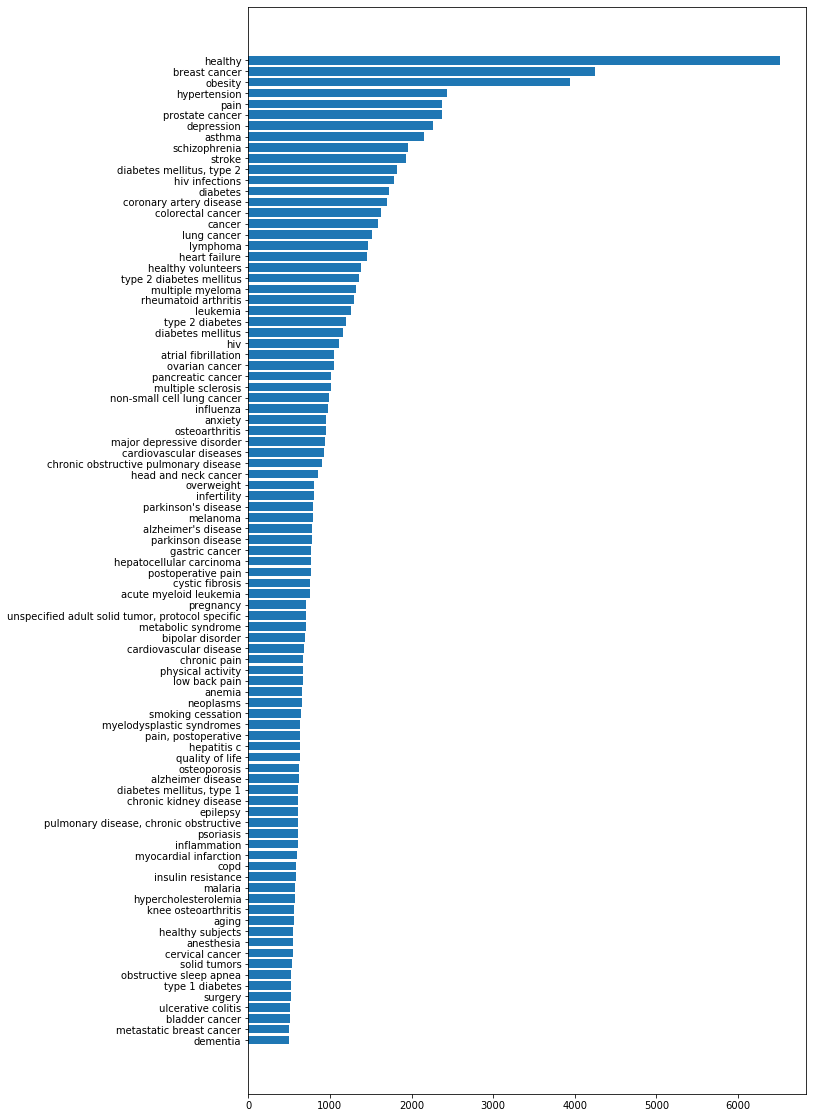

In [9]:
fig = plt.figure(figsize=(10, 20))
fig.tight_layout()
plt.barh(s_sig.index, s_sig)
plt.gca().invert_yaxis()
plt.show()

In [22]:
s_counts[:1000].sum() / s_counts.sum()

0.5301180535560035

In [23]:
# manually map the top 1000 conditions
pd.DataFrame(s_counts)[0:1000].to_csv('manual_maps/top_conditions_unmapped.csv')

### work in excel to map the top 1000 conditions

In [24]:
df_mapped = pd.read_csv('manual_maps/top_conditions.csv', index_col='downcase_name')
s_g_counts = df_mapped.groupby('cond_group')['counts'].sum().sort_values(ascending=False)

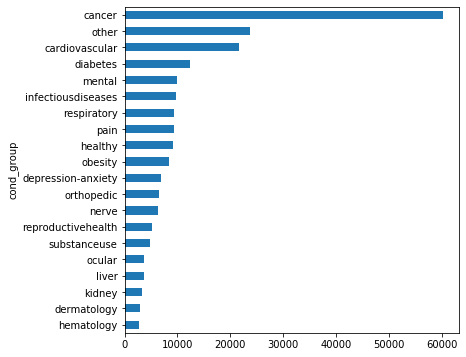

In [25]:
s_g_counts.plot.barh(figsize=(6,6))
plt.gca().invert_yaxis()
plt.show()

In [26]:
# for mapping conditions to their groups
cond2grp = df_mapped['cond_group'].to_dict()

### Let's look at the distribution of diseases over time

In [27]:
ss.studies.shape

(252613, 65)

In [28]:
c.data['category'] = c.data['downcase_name'].progress_apply(lambda x: cond2grp[x] 
                                                            if x in cond2grp.keys() 
                                                            else 'other')

100%|██████████| 416760/416760 [00:00<00:00, 1192239.97it/s]


In [29]:
all_categories = list(s_g_counts.index)
all_categories

['cancer',
 'other',
 'cardiovascular',
 'diabetes',
 'mental',
 'infectiousdiseases',
 'respiratory',
 'pain',
 'healthy',
 'obesity',
 'depression-anxiety',
 'orthopedic',
 'nerve',
 'reproductivehealth',
 'substanceuse',
 'ocular',
 'liver',
 'kidney',
 'dermatology',
 'hematology']

In [30]:
# method for combining all of the categories for a study
def combine_all_grps(df, nct_id):
    all_cond_grps = []
    if nct_id in df.index:
        sub_df = df.loc[[nct_id]]
        for cur_cat in sub_df['category']:
            if cur_cat not in all_cond_grps:
                all_cond_grps.append(cur_cat)
    return all_cond_grps

In [31]:
s_cats = ss.studies.reset_index()['nct_id'].progress_apply(lambda x: combine_all_grps(c.data, x)).values

100%|██████████| 252613/252613 [01:45<00:00, 2392.67it/s]


In [32]:
ss.studies['cond_categories'] = s_cats
ss.studies[['cond_categories']].head()

,cond_categories
nct_id,
NCT00690924,"[cancer, substanceuse]"
NCT00690898,[other]
NCT00690885,"[respiratory, other]"
NCT00690872,[cancer]
NCT00690846,[other]


### we now have a column that has a list representation of the categories per study

## Next, we can get the dummy variables per category

In [33]:
for cur_cat in all_categories:
    ss.studies['is_' + cur_cat] = ss.studies['cond_categories'].progress_apply(lambda x: 1 
                                                                               if cur_cat in x
                                                                               else 0)

100%|██████████| 252613/252613 [00:00<00:00, 1205382.13it/s]


In [34]:
ss.studies[['is_' + x for x in all_categories]].head()

,is_cancer,is_other,is_cardiovascular,is_diabetes,is_mental,is_infectiousdiseases,is_respiratory,is_pain,is_healthy,is_obesity,is_depression-anxiety,is_orthopedic,is_nerve,is_reproductivehealth,is_substanceuse,is_ocular,is_liver,is_kidney,is_dermatology,is_hematology
nct_id,,,,,,,,,,,,,,,,,,,,
NCT00690924,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
NCT00690898,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NCT00690885,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
NCT00690872,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NCT00690846,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
# let's see our count per category
dummy_categories = ['is_' + x for x in all_categories]
ss.studies[dummy_categories].sum()

is_cancer                 40613
is_other                 138884
is_cardiovascular         17992
is_diabetes               11035
is_mental                  8665
is_infectiousdiseases      7729
is_respiratory             8770
is_pain                    8887
is_healthy                 9289
is_obesity                 7113
is_depression-anxiety      5815
is_orthopedic              6080
is_nerve                   6203
is_reproductivehealth      4959
is_substanceuse            4155
is_ocular                  3134
is_liver                   3374
is_kidney                  2993
is_dermatology             2865
is_hematology              2491
dtype: int64

### Can group this by time windows and see what is studies at which times

In [36]:
ss.studies['start_year'] = ss.studies['start_date'].apply(lambda x: pd.Timestamp(x).year)

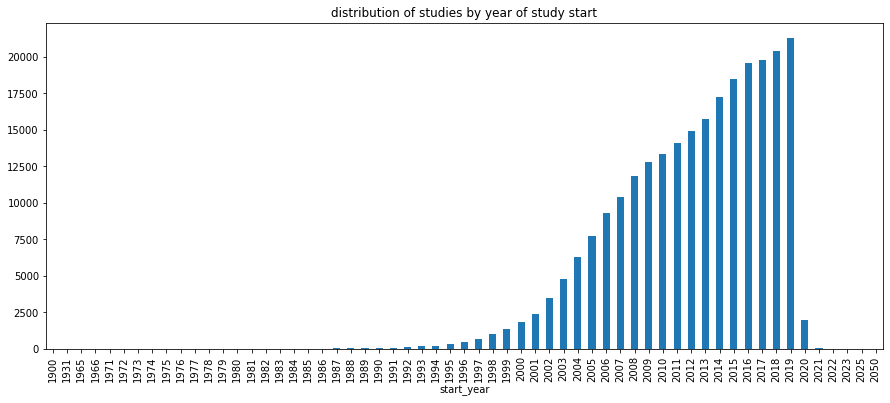

In [37]:
plt.figure(figsize=(15, 6))
ss.studies.groupby('start_year')['start_date'].count().plot.bar()
plt.title('distribution of studies by year of study start')
plt.show()

In [38]:
ss.studies.head(1).T.to_csv('example.csv')

In [39]:
# making a column with the year buckets
ss.studies['start_year_bucket'] = ss.studies['start_year'].apply(lambda x: '1999-' if x < 2000
                                                                 else ('2019+'
                                                                       if x > 2019 
                                                                       else str(x))
                                                                 )

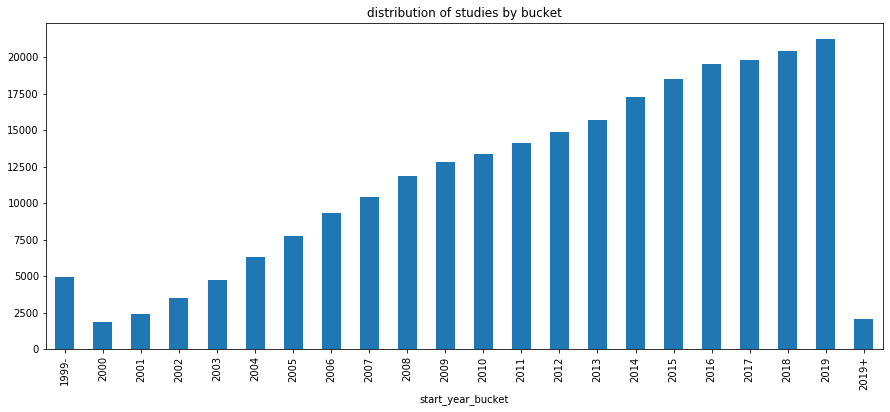

In [40]:
plt.figure(figsize=(15, 6))
ss.studies.groupby('start_year_bucket')['start_date'].count().plot.bar()
plt.title('distribution of studies by bucket')
plt.show()

### Now we can compute the % of studies studying each subject

**since each study can study multiple conditions, this % can add up to more than 100%**

In [41]:
all_buckets = ss.studies['start_year_bucket'].unique()
all_buckets

array(['2008', '2007', '2003', '2005', '2001', '2006', '2002', '2009',
       '2004', '1999-', '2000', '2012', '2011', '2019', '2010', '2013',
       '2018', '2015', '2017', '2019+', '2014', '2016'], dtype=object)

In [42]:
# calculating % studies in each bucket
bucket_dict = {}
for cur_bucket in all_buckets:
    sub_df = ss.studies[ss.studies['start_year_bucket'] == cur_bucket]
    bucket_dict[cur_bucket] = sub_df[dummy_categories].sum() / sub_df.shape[0]

In [43]:
# this data frame now contains the % of all studies in that year used on a certain group of studies
df_pcts = pd.DataFrame(bucket_dict)[sorted(bucket_dict.keys())]
df_pcts.reset_index()
df_pcts.index = df_pcts.reset_index()['index'].apply(lambda x: x[3:])
df_pcts.head()

,1999-,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2019+
index,,,,,,,,,,,,,,,,,,,,,
cancer,0.446977,0.428264,0.341423,0.269021,0.240168,0.226905,0.215544,0.201271,0.189083,0.175213,...,0.139970,0.130081,0.124172,0.124768,0.136263,0.133193,0.132178,0.130946,0.136522,0.132176
other,0.361897,0.369694,0.390795,0.404823,0.419979,0.419426,0.423057,0.452509,0.463753,0.468615,...,0.534213,0.567560,0.577050,0.579740,0.565321,0.594893,0.639881,0.645422,0.652982,0.665702
cardiovascular,0.072257,0.061257,0.067782,0.072639,0.087066,0.086674,0.090415,0.083674,0.083277,0.078145,...,0.076296,0.071289,0.074058,0.070352,0.065456,0.067083,0.062023,0.061284,0.060243,0.070429
diabetes,0.021168,0.032778,0.041423,0.048521,0.045216,0.047378,0.050389,0.053952,0.051603,0.051618,...,0.048146,0.047773,0.045593,0.045202,0.041187,0.038837,0.035709,0.034194,0.036729,0.028461
mental,0.020761,0.033315,0.038912,0.035889,0.040799,0.043892,0.039508,0.037476,0.035525,0.039875,...,0.030348,0.033595,0.028782,0.031236,0.032269,0.034846,0.032274,0.035566,0.038563,0.053063


### let's normalize the data to without "other" and drop really old and anticipated studies

In [44]:
df_no_other = df_pcts.drop("other").drop(['2019+', '1999-'], axis=1)
df_no_other = df_no_other / df_no_other.sum()
df_no_other.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
index,,,,,,,,,,,,,,,,,,,,
cancer,0.518543,0.428571,0.342847,0.311172,0.292424,0.284008,0.272489,0.265801,0.253514,0.240014,0.229286,0.219528,0.214849,0.209813,0.208341,0.224328,0.225974,0.228160,0.226180,0.232296
cardiovascular,0.074170,0.085084,0.092572,0.112807,0.111701,0.119133,0.113282,0.117066,0.113067,0.108797,0.112303,0.119662,0.117745,0.125134,0.117476,0.107759,0.113812,0.107062,0.105855,0.102505
diabetes,0.039688,0.051996,0.061837,0.058583,0.061058,0.066394,0.073043,0.072540,0.074685,0.082508,0.076923,0.075512,0.078904,0.077039,0.075479,0.067806,0.065891,0.061639,0.059062,0.062495
mental,0.040338,0.048845,0.045737,0.052861,0.056565,0.052057,0.050736,0.049939,0.057695,0.046205,0.047934,0.047598,0.055488,0.048634,0.052158,0.053123,0.059120,0.055711,0.061432,0.065616
infectiousdiseases,0.042941,0.051471,0.057812,0.058583,0.056157,0.061615,0.062254,0.059007,0.051705,0.060430,0.052043,0.047820,0.046499,0.047773,0.043062,0.046628,0.041236,0.038187,0.034270,0.036489


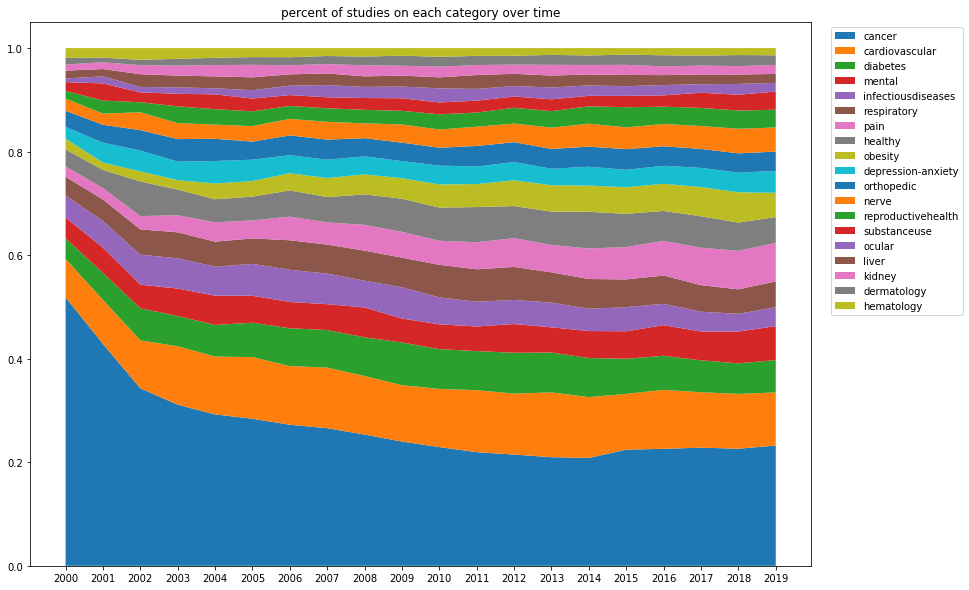

In [45]:
# exludes "other"
plt.figure(figsize=(14,10))
plt.stackplot(df_no_other.columns, 
              [df_no_other.loc[x].values for x in df_no_other.index], 
              labels=df_no_other.index)

plt.legend(bbox_to_anchor=(1.2,1))
plt.title('percent of studies on each category over time')
plt.show()

### let's unstack them to see what is increasing / decreasing over time

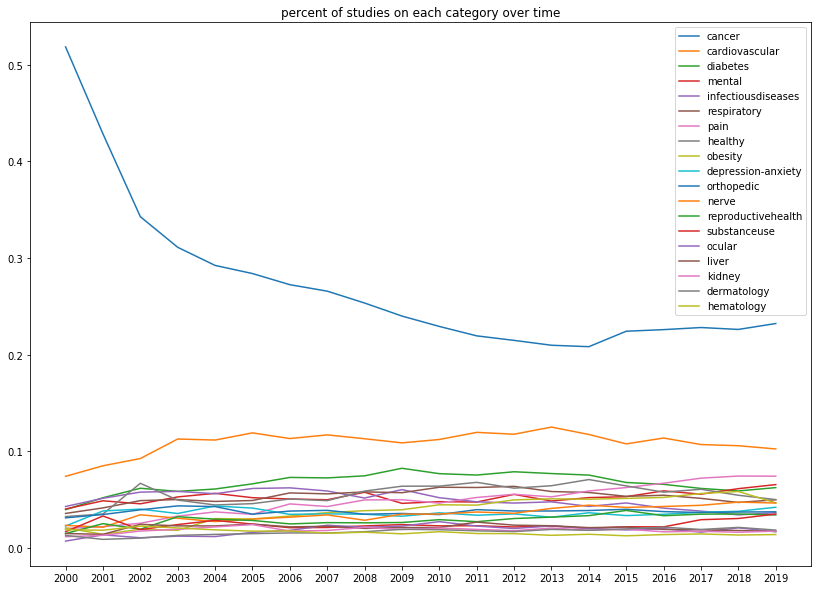

In [46]:
plt.figure(figsize=(14,10))
for idx in df_no_other.index:
    plt.plot(df_no_other.loc[idx].T, label=idx)
    
plt.legend(bbox_to_anchor=(1,1))
plt.title('percent of studies on each category over time')
plt.show()

### we can normalize the data by their 2000 ratios

In [47]:
df_indexed_2007 = df_no_other/ df_no_other['2007'][:, np.newaxis]

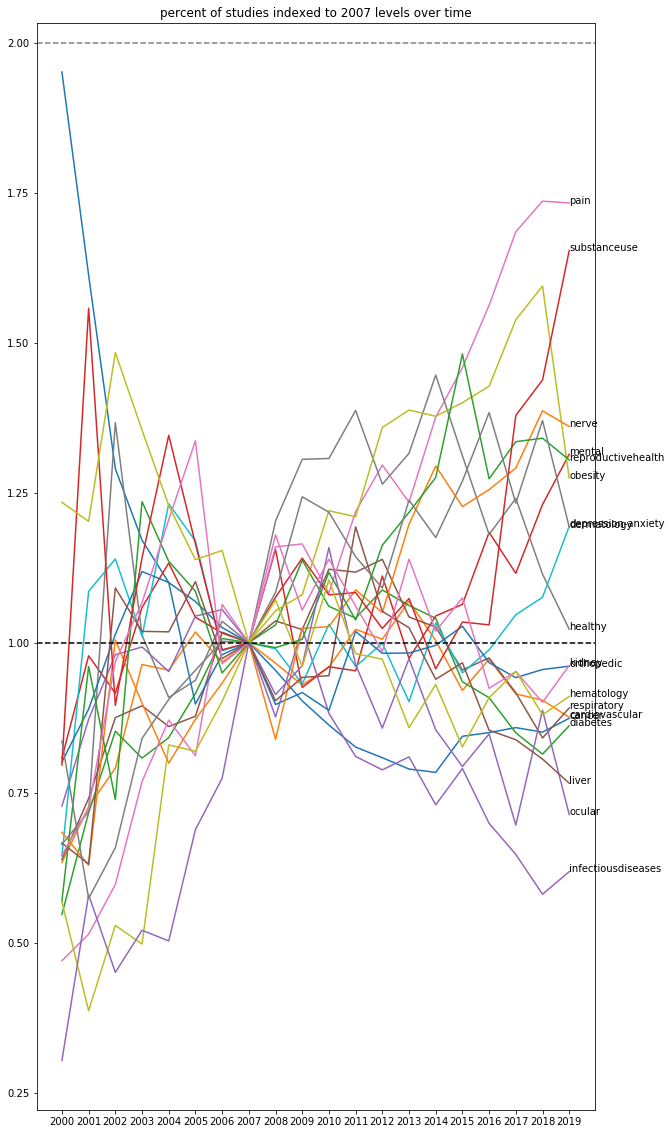

In [53]:
plt.figure(figsize=(10,20))
for idx in df_indexed_2007.index:
    plt.plot(df_indexed_2007.loc[idx].T, label=idx)
    
#plt.legend(bbox_to_anchor=(1,1))
plt.title('percent of studies indexed to 2007 levels over time')

for idx in df_indexed_2007['2019'].index:
    plt.annotate(xy=[19, df_indexed_2007['2019'][idx]], s=idx)
    
plt.axhline(1., linestyle='--', color='k')
plt.axhline(2., linestyle='--', color='k', alpha=0.5)
plt.show()

### This is a bit crowded, so let's plot 6/7 at a time

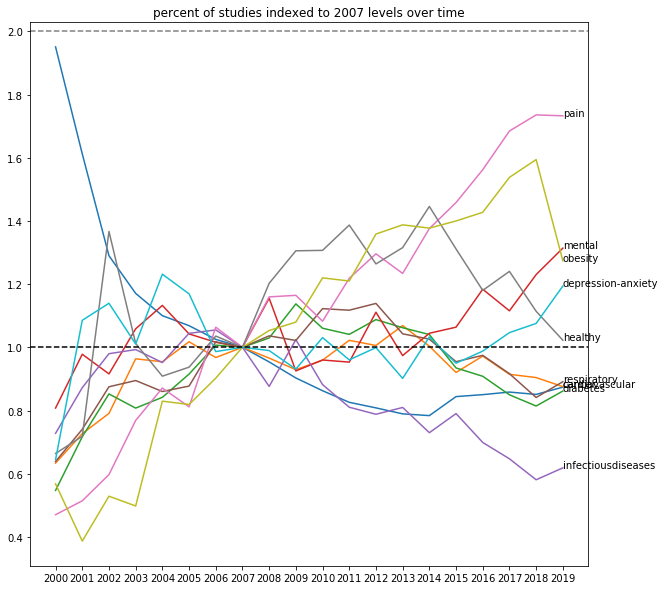

In [54]:
cur_df = df_indexed_2007[0:10]

plt.figure(figsize=(10,10))
for idx in cur_df.index:
    plt.plot(cur_df.loc[idx].T, label=idx)
    
#plt.legend(bbox_to_anchor=(1,1))
plt.title('percent of studies indexed to 2007 levels over time')

for idx in cur_df['2019'].index:
    plt.annotate(xy=[19, cur_df['2019'][idx]], s=idx)
    
plt.axhline(1., linestyle='--', color='k')
plt.axhline(2., linestyle='--', color='k', alpha=0.5)
plt.show()

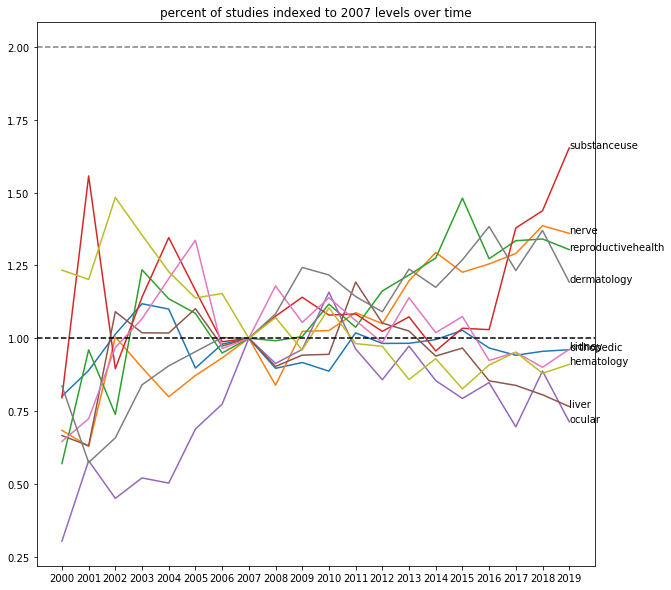

In [55]:
cur_df = df_indexed_2007[10:]

plt.figure(figsize=(10,10))
for idx in cur_df.index:
    plt.plot(cur_df.loc[idx].T, label=idx)
    
#plt.legend(bbox_to_anchor=(1,1))
plt.title('percent of studies indexed to 2007 levels over time')

for idx in cur_df['2019'].index:
    plt.annotate(xy=[19, cur_df['2019'][idx]], s=idx)
    
plt.axhline(1., linestyle='--', color='k')
plt.axhline(2., linestyle='--', color='k', alpha=0.5)
plt.show()

# Now we will build the pivatable dataframe

In [56]:
ss.studies.columns

Index(['nlm_download_date_description', 'study_first_submitted_date',
       'results_first_submitted_date', 'disposition_first_submitted_date',
       'last_update_submitted_date', 'study_first_submitted_qc_date',
       'study_first_posted_date', 'study_first_posted_date_type',
       'results_first_submitted_qc_date', 'results_first_posted_date',
       'results_first_posted_date_type', 'disposition_first_submitted_qc_date',
       'disposition_first_posted_date', 'disposition_first_posted_date_type',
       'last_update_submitted_qc_date', 'last_update_posted_date',
       'last_update_posted_date_type', 'start_month_year', 'start_date_type',
       'start_date', 'verification_month_year', 'verification_date',
       'completion_month_year', 'completion_date_type', 'completion_date',
       'primary_completion_month_year', 'primary_completion_date_type',
       'primary_completion_date', 'target_duration', 'study_type', 'acronym',
       'baseline_population', 'brief_title', 'offic

In [57]:
df = ss.studies[['start_date', 'start_date_type', 'enrollment_type', 'verification_date', 
                 'phase', 'number_of_arms', 'source', 'cond_categories', 'start_year']]
df

,start_date,start_date_type,enrollment_type,verification_date,phase,number_of_arms,source,cond_categories,start_year
nct_id,,,,,,,,,
NCT00690924,2008-07-17,Actual,Actual,2018-05-31,N/A,1.0,Roswell Park Cancer Institute,"[cancer, substanceuse]",2008
NCT00690898,2008-05-31,None,Actual,2019-01-31,Phase 3,1.0,Ipsen,[other],2008
NCT00690885,2008-06-30,None,Actual,2012-04-30,Phase 2,2.0,"Amarillo Biosciences, Inc.","[respiratory, other]",2008
NCT00690872,2008-07-31,None,Anticipated,2009-06-30,Phase 2,NaN,National Cancer Institute (NCI),[cancer],2008
NCT00690846,2007-07-31,Anticipated,Actual,2018-07-31,Phase 2,1.0,Wake Forest University Health Sciences,[other],2007
...,...,...,...,...,...,...,...,...,...
NCT00691002,2008-05-31,None,Actual,2010-01-31,Phase 3,4.0,LEO Pharma,[dermatology],2008
NCT00690976,2008-07-31,None,Anticipated,2010-03-31,N/A,2.0,Centers for Disease Control and Prevention,[infectiousdiseases],2008
NCT00690963,2008-09-30,None,Actual,2016-04-30,Phase 1/Phase 2,NaN,AHS Cancer Control Alberta,[cancer],2008


## All the subsequent code will be how to add extra columns to this dataframe

### let's crawl the conditions table to see if they are orphan diseases

In [58]:
orph_list = pickle.load(open('raw_data/orphan_list.pkl', 'rb'))
orph_list[:10]

FileNotFoundError: [Errno 2] No such file or directory: 'raw_data/orphan_list.pkl'

In [59]:
ss.dimensions['conditions'].data.head()

,id,name,downcase_name,category
nct_id,,,,
NCT00000113,538926,Myopia,myopia,ocular
NCT00000114,538925,Retinitis Pigmentosa,retinitis pigmentosa,ocular
NCT00000115,538924,"Macular Edema, Cystoid","macular edema, cystoid",other
NCT00000116,538923,Retinitis Pigmentosa,retinitis pigmentosa,ocular
NCT00000117,538922,Optic Neuritis,optic neuritis,other


In [62]:
SIM_THRESH = 90  # the match score has to be greater than this

In [72]:
def extract_highest_fuzz(x):
    return process.extract(x, orph_list, scorer=fuzz.ratio, limit=1)[0]

In [68]:
try_df = ss.dimensions['conditions'].data[:1000].copy()
try_df.shape

(1000, 4)

In [74]:
try_df['orph_match'] = try_df['downcase_name'].apply(extract_highest_fuzz)

In [76]:
try_df[['closest_orphan', 'orph_score']] = pd.DataFrame(try_df['orph_match'].values.tolist(), index=try_df.index)

In [81]:
try_df.shape

(1000, 7)

In [82]:
df_orph = try_df[try_df['orph_score'] > SIM_THRESH]
df_orph.shape

(40, 7)

In [83]:
df_orph.head()

,id,name,downcase_name,category,orph_match,closest_orphan,orph_score
nct_id,,,,,,,
NCT00000114,10059527,Retinitis Pigmentosa,retinitis pigmentosa,ocular,"(retinitis pigmentosa, 100)",retinitis pigmentosa,100
NCT00000116,10059525,Retinitis Pigmentosa,retinitis pigmentosa,ocular,"(retinitis pigmentosa, 100)",retinitis pigmentosa,100
NCT00000117,10059524,Optic Neuritis,optic neuritis,other,"(optic neuritis, 100)",optic neuritis,100
NCT00000118,10059522,Acquired Immunodeficiency Syndrome,acquired immunodeficiency syndrome,other,"(aquired immunodeficiency syndrome, 99)",aquired immunodeficiency syndrome,99
NCT00000118,10059523,Cytomegalovirus Retinitis,cytomegalovirus retinitis,other,"(cytomegalovirus retinitis, 100)",cytomegalovirus retinitis,100


## Joining sponsors

In [184]:
cur_df = ss.dimensions['sponsors'].data
cur_df.head()

,id,agency_class,lead_or_collaborator,name
nct_id,,,,
NCT00000113,9238044,Other,lead,Stony Brook University
NCT00000113,9238045,NIH,collaborator,National Eye Institute (NEI)
NCT00000114,9238043,NIH,lead,National Eye Institute (NEI)
NCT00000115,9238042,NIH,lead,National Eye Institute (NEI)
NCT00000116,9238041,NIH,lead,National Eye Institute (NEI)


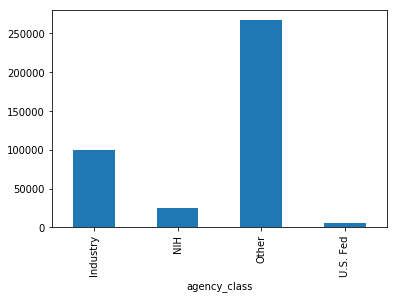

In [185]:
s_agency_class = cur_df.groupby('agency_class')['name'].count()
s_agency_class.plot.bar();plt.show()

In [186]:
# how many studies have sponsors
cur_df.index.unique().shape

(250136,)

In [187]:
# how many leads do we have
cur_df[cur_df['lead_or_collaborator'] == 'lead'].index.unique().shape

(250136,)

In [192]:
df_lead = cur_df[cur_df['lead_or_collaborator'] == 'lead']
df_lead.shape

(250136, 4)

In [193]:
df_lead.columns = ['sponsor_' + x for x in df_lead.columns]

In [194]:
dfj = df.join(df_lead[['sponsor_agency_class', 'sponsor_name']])

In [195]:
df.shape, dfj.shape

((250136, 9), (250136, 11))

In [197]:
df = dfj  # overriding original df

### Country

In [198]:
cur_df = ss.dimensions['countries'].data
cur_df.head()

,id,name,removed
nct_id,,,
NCT00000113,9136428,United States,None
NCT00000116,9136427,United States,None
NCT00000117,9136426,United States,None
NCT00000119,9136425,United States,None
NCT00000132,9136423,Sweden,None


In [169]:
def generate_countries_list(x):
    if x not in cur_df.index:
        return []
    else:
        return list(cur_df.loc[[x]]['name'].values)

In [166]:
trial_df = df[:1000].copy()

In [ ]:
df['countries'] = df.reset_index()['nct_id'].progress_apply(generate_countries_list).values

In [199]:
trial_df['countries'] = trial_df.reset_index()['nct_id'].apply(generate_countries_list).values
trial_df[['countries']].head()

,countries
nct_id,
NCT01980888,"[Australia, Belgium, Canada, Croatia, Czechia,..."
NCT01980875,"[Australia, Belgium, Canada, France, Poland, S..."
NCT01980849,[China]
NCT01980836,[Israel]
NCT01980823,[United States]


### final results:

In [200]:
df.head()

,start_date,start_date_type,enrollment_type,verification_date,phase,number_of_arms,source,cond_categories,start_year,sponsor_agency_class,sponsor_name
nct_id,,,,,,,,,,,
NCT01980888,2014-02-05,Actual,Actual,2017-09-30,Phase 3,2.0,Gilead Sciences,[cancer],2014,Industry,Gilead Sciences
NCT01980875,2015-04-21,Actual,Actual,2017-05-31,Phase 3,3.0,Gilead Sciences,[cancer],2015,Industry,Gilead Sciences
NCT01980849,2013-11-30,None,Anticipated,2013-11-30,Phase 3,2.0,Fourth Military Medical University,[cancer],2013,Other,Shengqing Li
NCT01980836,2013-11-30,None,Anticipated,2013-11-30,Phase 4,2.0,Tel-Aviv Sourasky Medical Center,"[orthopedic, other]",2013,Other,Tel-Aviv Sourasky Medical Center
NCT01980823,2013-10-31,Actual,Anticipated,2019-07-31,Early Phase 1,1.0,Columbia University,"[cancer, other]",2013,Other,Columbia University


In [52]:
df.to_pickle('raw_data/drug_demo.pkl')

NameError: name 'df' is not defined